In [1]:
%load_ext autoreload
%autoreload 2
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

from m3util.viz.style import set_style
from m3util.viz.layout import layout_fig
from dl_utils.utils.utils import list_to_dict, sort_tasks_by_size
from dl_utils.utils.dataset import viz_dataloader, split_train_valid, hdf5_dataset
from dl_utils.training.build_model import resnet50_, fpn_resnet50_classification, xcit_small
from dl_utils.analysis.case_analysis import prediction_vs_actual, most_confused_pairs, show_prediction_example
from dl_utils.analysis.confusion_matrix import plot_cm, show_multiple_cm
from dl_utils.analysis.attention_map import AttentionMapVisualizer
from dl_utils.packed_functions import viz_4confusion_matrix, plot_attention_map
set_style("printing")

symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)
bs = 256
num_workers = 1

# imagenet
imagenet_ds = hdf5_dataset('../../datasets/imagenet_v5_rot_10m.h5', folder='train', transform=transforms.ToTensor(), classes=symmetry_classes)
train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
# viz_dataloader(train_dl, label_converter=label_converter, title='imagenet - train')
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
# viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')

# atom
atom_ds = hdf5_dataset('../../datasets/atom_v5_rot_200k.h5', folder='atom', transform=transforms.ToTensor(), classes=symmetry_classes)
atom_dl = DataLoader(atom_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
# viz_dataloader(atom_dl, label_converter=label_converter, title='atom - cv')

# noise
noise_ds = hdf5_dataset('../../datasets/noise_v5_rot_100k.h5', folder='noise', transform=transforms.ToTensor(), classes=symmetry_classes)
noise_dl = DataLoader(noise_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
# viz_dataloader(noise_dl, label_converter=label_converter, title='noise - cv')

printing set for seaborn


In [13]:
valid_dl.batch_size

256

In [18]:
valid_ds[[0,1,2]]

TypeError: Indexing elements must be in increasing order

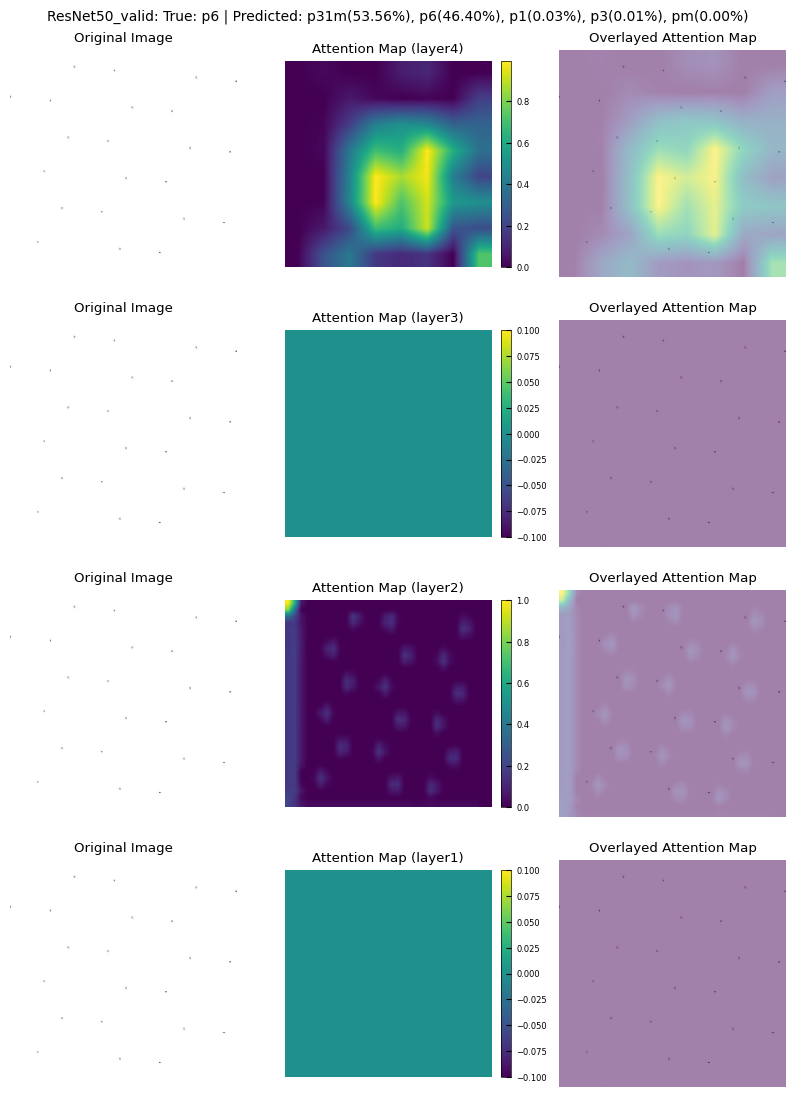

In [2]:
device = torch.device('cuda:9')
model = resnet50_(in_channels=3, n_classes=len(symmetry_classes))
model.load_state_dict(torch.load('../../models/ResNet50/09112024-resnet50-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True, map_location=device))
model.eval()
layers = ['layer4', 'layer3', 'layer2', 'layer1']

input_image_np, attention_map_resized = plot_attention_map(model, valid_dl, copnfusion_pair=['p6', 'p31m'], layers=layers, model_type='ResNet50', task_name='ResNet50_valid', device=device)


In [3]:
input_image_np.shape, attention_map_resized.shape

((256, 256, 3), (256, 256))

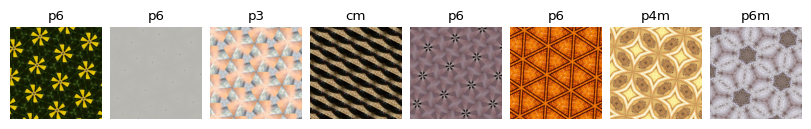

In [10]:
# imagenet
imagenet_ds = hdf5_dataset('../../datasets/imagenet_v5_rot_10m.h5', folder='train', transform=transforms.ToTensor(), classes=symmetry_classes)
train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')

In [11]:
metrics = valid_ds.list_metrics()
print("Available metrics:", metrics)

Available metrics: ['primitive_uc_vector_a', 'primitive_uc_vector_b', 'shape', 'translation_start_point', 'translation_uc_vector_a', 'translation_uc_vector_b']


In [40]:
from dl_utils.utils.dataset import verify_image_in_hdf5_file_symmetry_operation, verify_image_in_hdf5_file

Total number of images in the dataset:  204000
Randomly selected images:  [ 76467 130037 137540]


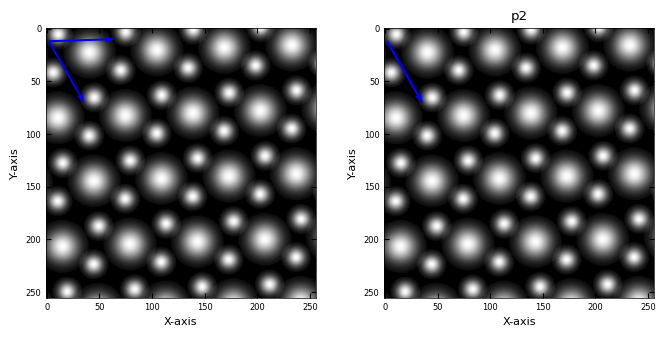

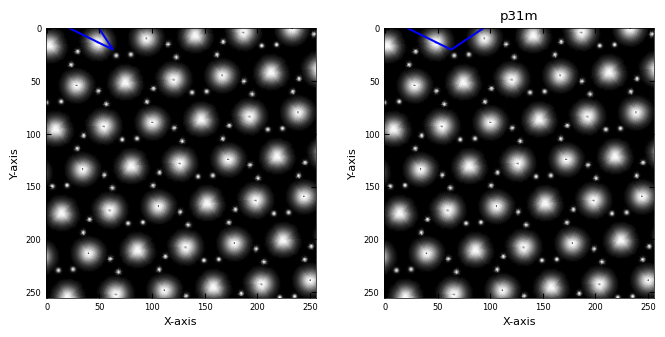

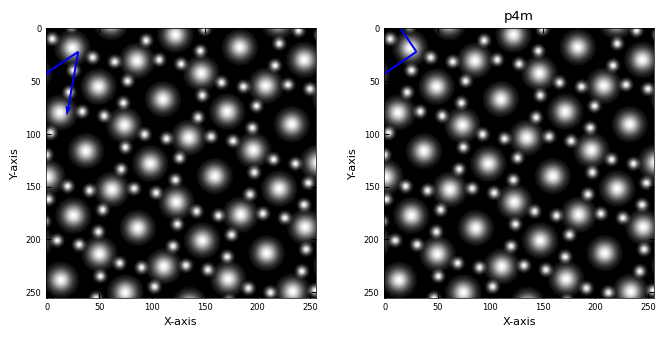

In [56]:
imgs, labels_str, metadata = verify_image_in_hdf5_file('../../datasets/atom_v5_rot_200k.h5', n_list=3, group='atom', viz=True)

Total number of images in the dataset:  10710034
Randomly selected images:  [  180141  7552479 10148200]


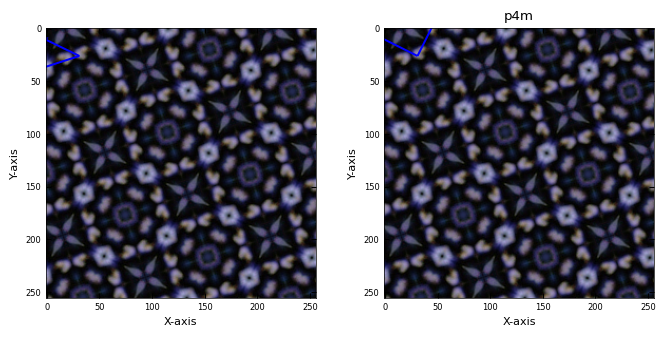

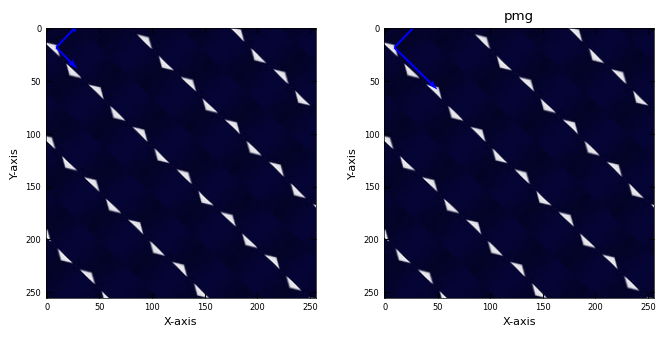

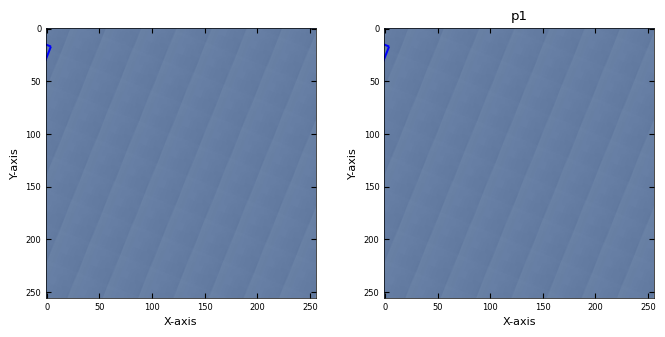

In [54]:
imgs, labels_str, metadata = verify_image_in_hdf5_file('../../datasets/imagenet_v5_rot_10m.h5', n_list=3, group='train', viz=True)